In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import os
import sys
sys.path.append('../')
sys.path.append('../../../src/utils')
from data_utils import *

2025-05-12 16:09:04.806591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

n_splits = 4
n_samples = [1000, 2000, 4000, 8000, 16000, 32000, 64000]

discretizations_sf = ['input_100']
discretizations_mf1 = ['input_10_25', 'input_10_25_50', 'input_10', 'input_25', 'input_50', 'input_25_50']
discretizations_mf2 = ['input_10_25', 'input_10_25_50', 'input_10']

# Initialize dictionary to store RMSE results
rmse_test_sf = {disc: [] for disc in discretizations_sf}
rmse_test_mf1 = {disc: [] for disc in discretizations_mf1}
rmse_test_mf2 = {disc: [] for disc in discretizations_mf2}

# Load training and test data for each discretization
X_train, y_train, X_test, y_test = prepare_data_single_fidelity(
    115200,
    f"../data/data/X_train_h1_100_01.csv",
    f"../data/data/y_train_h1_100_01.csv",
    f"../data/data/X_test_h1_100_01.csv",
    f"../data/data/y_test_h1_100_01.csv"
)

## SINGLE FIDELITY
rmse_test = []
for discretization in discretizations_sf:
    print(f"Processing discretization level: {discretization}")
    
    # Prepare data
    if discretization == 'input_100':
        X_train, y_train, X_test, y_test = prepare_data_single_fidelity(
            115200,
            "../data/data/X_train_h1_100_01.csv",
            "../data/data/y_train_h1_100_01.csv",
            "../data/data/X_train_h1_100_01.csv",
            "../data/data/y_train_h1_100_01.csv"
        )
        
    for n_sample in n_samples:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        X, y = X_train[:n_sample, :], y_train[:n_sample, :]
        rmse_test = []
        predictions_train = []
        predictions_test = []

        
        for fold_var, (train_index, val_index) in enumerate(kf.split(y), start=1):
            X_val_k = X[val_index,:]
            print(f"X_val_k shape: {X_val_k.shape}")
            y_val_k = y[val_index]

            # Load model and evaluate RMSE
            model_path = f'../models/single_fidelity_100/resolution_100/samples_{n_sample}/model_fold_{fold_var}.keras'
            model = load_model(model_path)
            rmse_test.append(np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2)))

        rmse_test_sf[discretization].append(rmse_test)
    
## MULTI FIDELITY 1
rmse_test = []
# Iterate over each discretization level
for discretization in discretizations_mf1:
    print(f"Processing discretization level: {discretization}")
    
    for n_sample in n_samples:

        # Prepare data
        if discretization == 'input_10':
            X_train_param, X_train_coarse1, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h4_100_01.csv"
                    )
            X_inputs = [X_train_param, X_train_coarse1]
            
        # Prepare data
        elif discretization == 'input_10_25':
            X_train_param, X_train_coarse1, X_train_coarse2, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv",
                       "../data/data/y_train_h4_100_01.csv"
                    )
            X_inputs = [X_train_param, X_train_coarse1, X_train_coarse2]
            
        elif discretization == 'input_10_25_50':
            X_train_param, X_train_coarse1, X_train_coarse2, X_train_coarse3, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h2_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv",
                       "../data/data/y_train_h4_100_01.csv"
                    )
            X_inputs = [X_train_param, X_train_coarse1, X_train_coarse2, X_train_coarse3]
            
        elif discretization == 'input_25':
            X_train_param, X_train_coarse1, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv",
                    )
            X_inputs = [X_train_param, X_train_coarse1]
        
        elif discretization == 'input_25_50':
            X_train_param, X_train_coarse1, X_train_coarse2, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h2_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv",
                    )
            X_inputs = [X_train_param, X_train_coarse1, X_train_coarse2]
            
        elif discretization == 'input_50':
            X_train_param, X_train_coarse1, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h2_100_01.csv",
                    )
            X_inputs = [X_train_param, X_train_coarse1]

        # Perform k-fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=56)
        rmse_test = []

        for fold_var, (train_index, val_index) in enumerate(kf.split(y_train), start=1):
            X_val_k = [X[val_index] for X in X_inputs]
            y_val_k = y_train[val_index]

            # Load model and compute RMSE
            model_path = f"../models/multi_fidelity_100/{discretization}/samples_{n_sample}/model_fold_{fold_var}.keras"
            model = load_model(model_path)
            rmse = np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2))
            rmse_test.append(rmse)

        # Store RMSE results for the current sample size and discretization
        rmse_test_mf1[discretization].append(rmse_test)

## MULTI FIDELITY 2
rmse_test = []
# Iterate over each discretization level

for discretization in discretizations_mf2:
    print(f"Processing discretization level: {discretization}")
    
    for n_sample in n_samples:
        if discretization == 'input_10':
            X_train_param, X_train_coarse1, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/predictions_single_fidelity_100/resolution_10/samples_64000/predictions_train.csv",
                    )
            X_inputs = [X_train_param, X_train_coarse1]
        # Prepare data
        elif discretization == 'input_10_25':
            X_train_param, X_train_coarse1, X_train_coarse2, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv",
                       "../data/predictions_single_fidelity_100/resolution_10/samples_64000/predictions_train.csv",
                    )
            X_inputs = [X_train_param, X_train_coarse1, X_train_coarse2]
        elif discretization == 'input_10_25_50':
            X_train_param, X_train_coarse1, X_train_coarse2, X_train_coarse3, y_train = prepare_data_multi_fidelity(
                       n_sample,
                       "../data/data/y_train_h1_100_01.csv",
                       "../data/data/X_train_h1_100_01.csv",
                       "../data/data/y_train_h2_100_01.csv",
                       "../data/data/y_train_h3_100_01.csv",
                       "../data/predictions_single_fidelity_100/resolution_10/samples_64000/predictions_train.csv",
                    )
            X_inputs = [X_train_param, X_train_coarse1, X_train_coarse2, X_train_coarse3]
            
        # Perform k-fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=56)
        rmse_test = []

        for fold_var, (train_index, val_index) in enumerate(kf.split(y_train), start=1):
            X_val_k = [X[val_index] for X in X_inputs]
            y_val_k = y_train[val_index]

            # Load model and compute RMSE
            model_path = f"../models/multi_fidelity_100_2step/{discretization}/samples_{n_sample}/model_fold_{fold_var}.keras"
            model = load_model(model_path)
            rmse = np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2))
            rmse_test.append(rmse)

        # Store RMSE results for the current sample size and discretization
        rmse_test_mf2[discretization].append(rmse_test)

Processing discretization level: input_100
X_val_k shape: (250, 64)
X_val_k shape: (250, 64)
X_val_k shape: (250, 64)
X_val_k shape: (250, 64)
X_val_k shape: (500, 64)
X_val_k shape: (500, 64)
X_val_k shape: (500, 64)
X_val_k shape: (500, 64)
X_val_k shape: (1000, 64)
X_val_k shape: (1000, 64)
X_val_k shape: (1000, 64)
X_val_k shape: (1000, 64)
X_val_k shape: (2000, 64)
X_val_k shape: (2000, 64)
X_val_k shape: (2000, 64)
X_val_k shape: (2000, 64)
X_val_k shape: (4000, 64)
X_val_k shape: (4000, 64)
X_val_k shape: (4000, 64)
X_val_k shape: (4000, 64)
X_val_k shape: (8000, 64)
X_val_k shape: (8000, 64)
X_val_k shape: (8000, 64)
X_val_k shape: (8000, 64)
X_val_k shape: (16000, 64)
X_val_k shape: (16000, 64)
X_val_k shape: (16000, 64)
X_val_k shape: (16000, 64)
Processing discretization level: input_10_25
Processing discretization level: input_10_25_50
Processing discretization level: input_10
Processing discretization level: input_25
Processing discretization level: input_50
Processing dis

In [6]:
N_SAMPLES = [1000, 2000, 4000, 8000, 16000, 32000, 64000]
def plot_rmse(discretizations, rmse_data, styles):
    for disc in discretizations:
        style = styles[disc]
        mean_rmse = np.mean(rmse_data[disc], axis=1)

        # Boxplot
        plt.boxplot(
            rmse_data[disc],
            positions=N_SAMPLES,
            widths=np.array(N_SAMPLES) * 0.1,
            patch_artist=True,
            boxprops=dict(facecolor=style['color'], edgecolor='gray', linewidth=0.5),
            medianprops=dict(color='black', linewidth=0.2),
            whiskerprops=dict(color=style['color'], linewidth=2.5),
            capprops=dict(color=style['color'], linewidth=2.5),
            showfliers=True
        )

        # Mean RMSE line
        plt.plot(
            N_SAMPLES,
            mean_rmse,
            label=style['label'],
            color=style['color'],
            linestyle=style['linestyle'],
            marker=style['marker'],
            linewidth=2,
            markersize=6
        )

# Plot 1

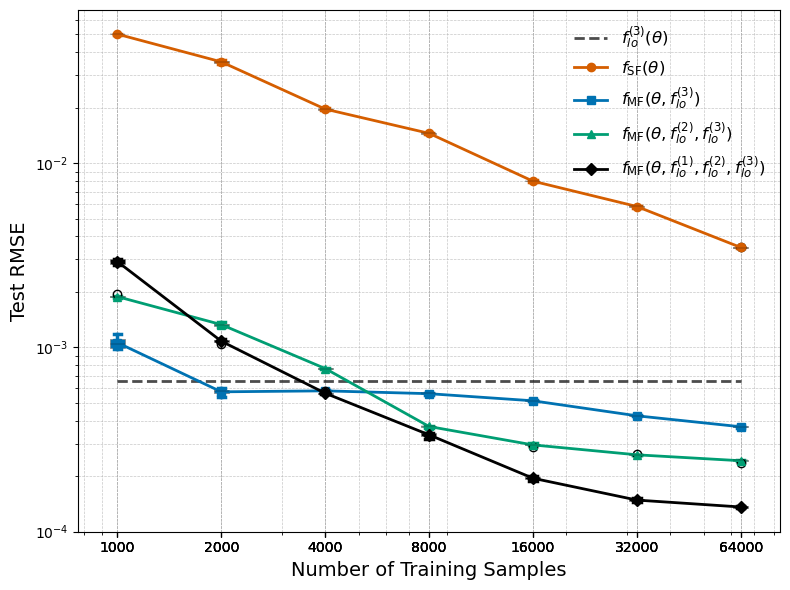

In [7]:
discretizations_sf_plot = ['input_100']
discretizations_mf1_plot = ['input_50', 'input_25_50', 'input_10_25_50']
discretizations_mf2_plot = []

plot_styles_sf = {
    'input_100': {
        'color': '#D55E00', 'marker': 'o', 'linestyle': '-', 'label': r'$f_{\mathrm{SF}}(\theta)$'
    }
}

plot_styles_mf1 = {
    'input_50': {
        'color': '#0072B2', 'marker': 's', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(3)})$'
    },
    'input_25_50': {
        'color': '#009E73', 'marker': '^', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(2)},f_{lo}^{(3)})$'
    },
    'input_10_25_50': {
        'color': '#000000', 'marker': 'D', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(1)},f_{lo}^{(2)},f_{lo}^{(3)})$'
    }
}

plot_styles_mf2 = {}  # Add more if needed

# Set up the figure
plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')

# Reference horizontal line
plt.plot(N_SAMPLES, [6.6e-4]*len(N_SAMPLES), 'k--', linewidth=2, alpha=0.7, label=r'$f_{lo}^{(3)}(\theta)$')

# Plotting sections
plot_rmse(discretizations_sf_plot, rmse_test_sf, plot_styles_sf)
plot_rmse(discretizations_mf1_plot, rmse_test_mf1, plot_styles_mf1)
plot_rmse(discretizations_mf2_plot, rmse_test_mf2, plot_styles_mf2)


# Labels and formatting
plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('Test RMSE', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=False, loc='upper right')
plt.tight_layout()
plt.savefig("../images/results_MF1.png", dpi=300)

plt.show()

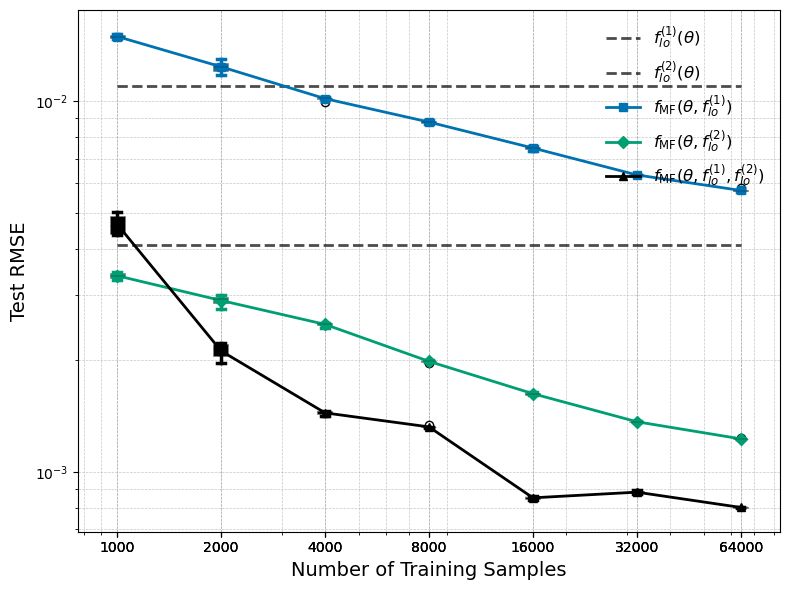

In [8]:
discretizations_sf_plot = []
discretizations_mf1_plot = ['input_10', 'input_25', 'input_10_25']
discretizations_mf2_plot = []

plot_styles_sf = {
}

plot_styles_mf1 = {
    'input_10': {
        'color': '#0072B2', 'marker': 's', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(1)})$'
    },
    'input_25': {
        'color': '#009E73', 'marker': 'D', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(2)})$'
    },
    'input_10_25': {
        'color': '#000000', 'marker': '^', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(1)},f_{lo}^{(2)})$'
    }
}

plot_styles_mf2 = {}  # Add more if needed

# Set up the figure
plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')

# Reference horizontal line
plt.plot(N_SAMPLES, [1.1e-2]*len(N_SAMPLES), 'k--', linewidth=2, alpha=0.7, label=r'$f_{lo}^{(1)}(\theta)$')
plt.plot(N_SAMPLES, [4.1e-3]*len(N_SAMPLES), 'k--', linewidth=2, alpha=0.7, label=r'$f_{lo}^{(2)}(\theta)$')

# Plotting sections
plot_rmse(discretizations_sf_plot, rmse_test_sf, plot_styles_sf)
plot_rmse(discretizations_mf1_plot, rmse_test_mf1, plot_styles_mf1)
plot_rmse(discretizations_mf2_plot, rmse_test_mf2, plot_styles_mf2)


# Labels and formatting
plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('Test RMSE', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=False, loc='upper right')
plt.tight_layout()
plt.savefig("../images/results_MF2.png", dpi=300)

plt.show()

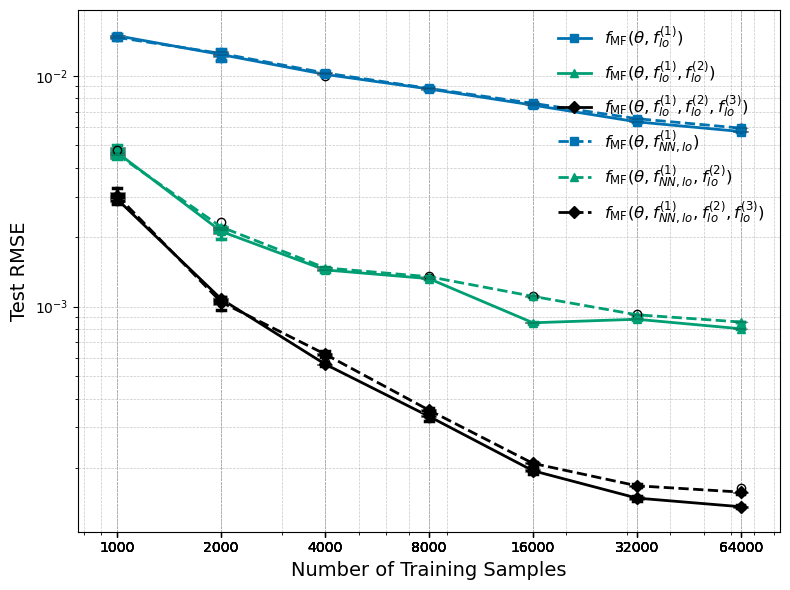

In [9]:
discretizations_sf_plot = []
discretizations_mf1_plot = ['input_10', 'input_10_25', 'input_10_25_50']
discretizations_mf2_plot = ['input_10', 'input_10_25', 'input_10_25_50']

plot_styles_sf = {
}
    
plot_styles_mf1 = {
    'input_10': {
        'color': '#0072B2', 'marker': 's', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(1)})$'
    },
    'input_10_25': {
        'color': '#009E73', 'marker': '^', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(1)},f_{lo}^{(2)})$'
    },
    'input_10_25_50': {
        'color': '#000000', 'marker': 'D', 'linestyle': '-', 'label': r'$f_{\mathrm{MF}}(\theta,f_{lo}^{(1)},f_{lo}^{(2)},f_{lo}^{(3)})$'
    }
}

plot_styles_mf2 = {
    'input_10': {
        'color': '#0072B2', 'marker': 's', 'linestyle': '--', 'label': r'$f_{\mathrm{MF}}(\theta,f_{NN,lo}^{(1)})$'
    },
    'input_10_25': {
        'color': '#009E73', 'marker': '^', 'linestyle': '--', 'label': r'$f_{\mathrm{MF}}(\theta,f_{NN,lo}^{(1)},f_{lo}^{(2)})$'
    },
    'input_10_25_50': {
        'color': '#000000', 'marker': 'D', 'linestyle': '--', 'label': r'$f_{\mathrm{MF}}(\theta,f_{NN,lo}^{(1)},f_{lo}^{(2)},f_{lo}^{(3)})$'
    }
}

# Set up the figure
plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')

# Plotting sections
plot_rmse(discretizations_sf_plot, rmse_test_sf, plot_styles_sf)
plot_rmse(discretizations_mf1_plot, rmse_test_mf1, plot_styles_mf1)
plot_rmse(discretizations_mf2_plot, rmse_test_mf2, plot_styles_mf2)


# Labels and formatting
plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('Test RMSE', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=False, loc='upper right')
plt.tight_layout()
plt.savefig("../images/results_MF3.png", dpi=300)

plt.show()